<a class="anchor" id="0"></a>

# FE, tuning and comparison of the 15 popular models for Cardiovascular Disease prediction

Build of the 15 most popular models, the most complex models from them are tuned (optimized) Comparison of the optimal for each type models.

<a class="anchor" id="0.1"></a>

## Table of Contents

1. [Import libraries](#1)
1. [Download datasets](#2)
1. [Preparing to modeling](#4)
1. [Tuning models and test for all features](#5)
    -  [Logistic Regression](#5.1)
    -  [Support Vector Machines](#5.2)
    -  [Linear SVC](#5.3)
    -  [k-Nearest Neighbors algorithm with GridSearchCV](#5.4)
    -  [Naive Bayes](#5.5)
    -  [Perceptron](#5.6)
    -  [Decision Tree Classifier](#5.7)
    -  [Random Forests with GridSearchCV](#5.8)
    -  [Stochastic Gradient Descent](#5.8)
    -  [XGB Classifier with HyperOpt](#5.10)
    -  [LGBM Classifier with HyperOpt](#5.11)
    -  [GradientBoostingClassifier with HyperOpt](#5.12)
    -  [RidgeClassifier](#5.13)
    -  [BaggingClassifier](#5.14)
    -  [ExtraTreesClassifier with HyperOpt](#5.15)    
1. [Models evaluation](#6)

## 1. Import libraries <a class="anchor" id="1"></a>

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import sklearn
%matplotlib inline

# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, jaccard_score
import pandas_profiling as pp

# models
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier 
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, VotingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

# model tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

## 2. Download datasets <a class="anchor" id="2"></a>

In [9]:
data = pd.read_csv("cardio_train.csv", sep=";")

In [10]:
data.drop("id",axis=1,inplace=True)
data.drop_duplicates(inplace=True)
data["bmi"] = data["weight"] / (data["height"]/100)**2
out_filter = ((data["ap_hi"]>250) | (data["ap_lo"]>200))
data = data[~out_filter]
len(data)

68983

In [11]:
out_filter2 = ((data["ap_hi"] < 0) | (data["ap_lo"] < 0))
data = data[~out_filter2]

In [12]:
data.head(3)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68975 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          68975 non-null  int64  
 1   gender       68975 non-null  int64  
 2   height       68975 non-null  int64  
 3   weight       68975 non-null  float64
 4   ap_hi        68975 non-null  int64  
 5   ap_lo        68975 non-null  int64  
 6   cholesterol  68975 non-null  int64  
 7   gluc         68975 non-null  int64  
 8   smoke        68975 non-null  int64  
 9   alco         68975 non-null  int64  
 10  active       68975 non-null  int64  
 11  cardio       68975 non-null  int64  
 12  bmi          68975 non-null  float64
dtypes: float64(2), int64(11)
memory usage: 7.4 MB


## 3. Preparing to modeling <a class="anchor" id="4"></a>


Spliting  data on 30% in the test dataset, the remaining 70% - in the training dataset

In [14]:
X = data[['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'bmi']].values
y = data['cardio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## 4. Tuning models and test for all features <a class="anchor" id="5"></a>

There are 60+ predictive modelling algorithms to choose from. We must understand the type of problem and solution requirement to narrow down to a select few models which we can evaluate. Our problem is a classification and regression problem. We want to identify relationship between output (Survived or not) with other variables or features (Gender, Age, Port...). We are also perfoming a category of machine learning which is called supervised learning as we are training our model with a given dataset. With these two criteria - Supervised Learning plus Classification and Regression, we can narrow down our choice of models to a few. These include:

- Logistic Regression
- Support Vector Machines and Linear SVC
- KNN or k-Nearest Neighbors
- Naive Bayes Classifier or Gaussian Naive Bayes
- Decision Tree Classifier, Random Forest
- Perceptron

### 4.1 Logistic Regression <a class="anchor" id="5.1"></a>


**Logistic Regression** is a useful model to run early in the workflow. Logistic regression measures the relationship between the categorical dependent variable (feature) and one or more independent variables (features) by estimating probabilities using a logistic function, which is the cumulative logistic distribution. Reference [Wikipedia](https://en.wikipedia.org/wiki/Logistic_regression).

Note the confidence score generated by the model based on our training dataset.

In [15]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression()

In [16]:
pred_test_log = logmodel.predict(X_test)
pred_log = logmodel.predict(X_train)

In [17]:
print(classification_report(y_test,pred_test_log))

              precision    recall  f1-score   support

           0       0.70      0.77      0.73      6877
           1       0.74      0.67      0.71      6918

    accuracy                           0.72     13795
   macro avg       0.72      0.72      0.72     13795
weighted avg       0.72      0.72      0.72     13795



In [18]:
acc_log = metrics.accuracy_score(y_train,pred_log ) * 100
acc_test_log = metrics.accuracy_score(y_test, pred_test_log) * 100
print("Accuracy train : ", acc_log)
print("Accuracy test : ", acc_test_log)

Accuracy train :  71.65277274374773
Accuracy test :  71.93910837259877


### 4.2 Support Vector Machines <a class="anchor" id="5.2"></a>


**Support Vector Machines** are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. Given a set of training samples, each marked as belonging to one or the other of two categories, an SVM training algorithm builds a model that assigns new test samples to one category or the other, making it a non-probabilistic binary linear classifier. Reference [Wikipedia](https://en.wikipedia.org/wiki/Support_vector_machine).

In [19]:
clf = svm.SVC(kernel='poly')
clf.fit(X_train, y_train) 

SVC(kernel='poly')

In [20]:
pred_svc = clf.predict(X_train)
pred_test_svc = clf.predict(X_test)
pred_test_svc [0:5]

array([1, 1, 0, 0, 0], dtype=int64)

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           0       0.60      0.64      0.62      6877
           1       0.62      0.58      0.60      6918

    accuracy                           0.61     13795
   macro avg       0.61      0.61      0.61     13795
weighted avg       0.61      0.61      0.61     13795

Confusion matrix, without normalization
[[4394 2483]
 [2935 3983]]


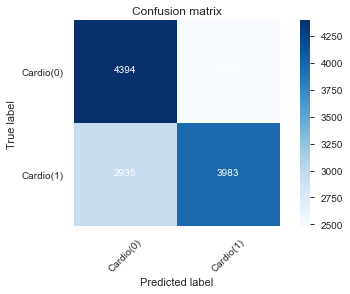

In [22]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, pred_test_svc, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test, pred_test_svc))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Cardio(0)','Cardio(1)'],normalize= False,  title='Confusion matrix')

In [23]:
acc_svc = accuracy_score(y_train,pred_svc) * 100
acc_test_svc = accuracy_score(y_test, pred_test_svc) * 100
print("Accuracy train : ", acc_svc)
print("Accuracy test : ", acc_test_svc)

Accuracy train :  61.495106922798115
Accuracy test :  60.724900326205145


### 4.3 Linear SVC <a class="anchor" id="5.3"></a>

**SVC** is a similar to SVM method. Its also builds on kernel functions but is appropriate for unsupervised learning. Reference [Wikipedia](https://en.wikipedia.org/wiki/Support-vector_machine#Support-vector_clustering_(SVC).

In [24]:
clf = svm.SVC(kernel='linear', C = 1.0)
clf.fit(X_train, y_train) 

SVC(kernel='linear')

In [25]:
pred_linear_svc = clf.predict(X_train)
pred_test_linear_svc = clf.predict(X_test)
pred_test_linear_svc [0:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [26]:
acc_linear_svc = accuracy_score(y_train,pred_linear_svc) * 100
acc_test_linear_svc = accuracy_score(y_test, pred_test_linear_svc) * 100
print("Accuracy train : ", acc_linear_svc)
print("Accuracy test : ", acc_test_linear_svc)

Accuracy train :  72.37404856832185
Accuracy test :  72.72924972816239


### 4.4 k-Nearest Neighbors algorithm <a class="anchor" id="5.4"></a>

In pattern recognition, the **k-Nearest Neighbors algorithm** (or k-NN for short) is a non-parametric method used for classification and regression. A sample is classified by a majority vote of its neighbors, with the sample being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). Reference [Wikipedia](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm).

In [27]:
k = 45
#Training and Predicting  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
pred_knn = neigh.predict(X_train)
pred_test_knn = neigh.predict(X_test)
pred_test_knn[0:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [28]:
Ks = 50
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    pred_test_knn=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, pred_test_knn)

    
    std_acc[n-1]=np.std(pred_test_knn==y_test)/np.sqrt(pred_test_knn.shape[0])

mean_acc

array([0.63, 0.63, 0.67, 0.67, 0.68, 0.69, 0.69, 0.69, 0.7 , 0.7 , 0.7 ,
       0.7 , 0.7 , 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71,
       0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71,
       0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71,
       0.71, 0.71, 0.71, 0.71, 0.71])

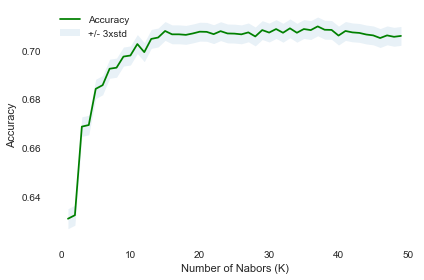

In [29]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [30]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.7098948894527003 with k= 37


In [31]:
acc_knn = accuracy_score(y_train, pred_knn) * 100
acc_test_knn = accuracy_score(y_test, pred_test_knn) * 100
print("Accuracy train : ", acc_knn)
print("Accuracy test : ", acc_test_knn)

Accuracy train :  72.13301920985865
Accuracy test :  70.59804276911925


### 4.5 Naive Bayes <a class="anchor" id="5.5"></a>

In machine learning, **Naive Bayes classifiers** are a family of simple probabilistic classifiers based on applying Bayes' theorem with strong (naive) independence assumptions between the features. Naive Bayes classifiers are highly scalable, requiring a number of parameters linear in the number of variables (features) in a learning problem. Reference [Wikipedia](https://en.wikipedia.org/wiki/Naive_Bayes_classifier).

In [32]:
#Training
model = GaussianNB()
model.fit(X_train, y_train)

#Prediction
pred_gaussian = model.predict(X_train)
pred_test_gaussian = model.predict(X_test)

In [33]:
acc_gaussian = accuracy_score(y_train, pred_gaussian) * 100
acc_test_gaussian = accuracy_score(y_test, pred_test_gaussian) * 100

print("Accuracy train : ", acc_gaussian)
print("Accuracy test : ", acc_test_gaussian)

Accuracy train :  70.2664008698804
Accuracy test :  70.26458861906488


### 4.6 Perceptron <a class="anchor" id="5.6"></a>

The **Perceptron** is an algorithm for supervised learning of binary classifiers (functions that can decide whether an input, represented by a vector of numbers, belongs to some specific class or not). It is a type of linear classifier, i.e. a classification algorithm that makes its predictions based on a linear predictor function combining a set of weights with the feature vector. The algorithm allows for online learning, in that it processes elements in the training set one at a time. Reference [Wikipedia](https://en.wikipedia.org/wiki/Perceptron).

In [34]:
perceptron = Perceptron()
perceptron.fit(X_train, y_train)

pred_perceptron = perceptron.predict(X_train)
pred_test_perceptron = perceptron.predict(X_test)


In [35]:
acc_perceptron = accuracy_score(y_train, pred_perceptron) * 100
acc_test_perceptron = accuracy_score(y_test, pred_test_perceptron) * 100

print("Accuracy train : ", acc_perceptron)
print("Accuracy test : ", acc_test_perceptron)

Accuracy train :  63.30010873504893
Accuracy test :  62.587894164552374


### 4.7 Decision Tree Classifier <a class="anchor" id="5.7"></a>

This model uses a **Decision Tree** as a predictive model which maps features (tree branches) to conclusions about the target value (tree leaves). Tree models where the target variable can take a finite set of values are called classification trees; in these tree structures, leaves represent class labels and branches represent conjunctions of features that lead to those class labels. Decision trees where the target variable can take continuous values (typically real numbers) are called regression trees. Reference [Wikipedia](https://en.wikipedia.org/wiki/Decision_tree_learning).

In [36]:
DecTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
DecTree.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [37]:
pred_decision_tree = DecTree.predict(X_train)
pred_test_decision_tree = DecTree.predict(X_test)

acc_decision_tree = metrics.accuracy_score(y_train, pred_decision_tree) * 100
acc_test_decision_tree = metrics.accuracy_score(y_test, pred_test_decision_tree) * 100

print("Accuracy train : ", acc_decision_tree)
print("Accuracy test : ", acc_test_decision_tree)

Accuracy train :  72.6766944545125
Accuracy test :  73.1279449075752


In [38]:
print(classification_report(y_test, pred_test_decision_tree))

              precision    recall  f1-score   support

           0       0.73      0.74      0.73      6877
           1       0.74      0.72      0.73      6918

    accuracy                           0.73     13795
   macro avg       0.73      0.73      0.73     13795
weighted avg       0.73      0.73      0.73     13795



### 4.8 Random Forests <a class="anchor" id="5.8"></a>

**Random Forests** is one of the most popular model. Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees (n_estimators= [100, 300]) at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. Reference [Wikipedia](https://en.wikipedia.org/wiki/Random_forest).

In [39]:
rfc = RandomForestClassifier(n_estimators=600)
rfc.fit(X_train,y_train)

RandomForestClassifier(n_estimators=600)

In [40]:
#predictions
pred_random_forest = rfc.predict(X_train)
pred_test_random_forest = rfc.predict(X_test)

#Evaluation
acc_random_forest = metrics.accuracy_score(y_train, pred_random_forest) * 100
acc_test_random_forest = metrics.accuracy_score(y_test, pred_test_random_forest) * 100

print("Accuracy train : ", acc_random_forest)
print("Accuracy test : ", acc_test_random_forest)

Accuracy train :  99.98187749184487
Accuracy test :  71.5911562160203


### 4.9 Stochastic Gradient Descent<a class="anchor" id="5.9"></a>

**Stochastic gradient descent** (often abbreviated **SGD**) is an iterative method for optimizing an objective function with suitable smoothness properties (e.g. differentiable or subdifferentiable). It can be regarded as a stochastic approximation of gradient descent optimization, since it replaces the actual gradient (calculated from the entire data set) by an estimate thereof (calculated from a randomly selected subset of the data). Especially in big data applications this reduces the computational burden, achieving faster iterations in trade for a slightly lower convergence rate. Reference [Wikipedia](https://en.wikipedia.org/wiki/Stochastic_gradient_descent).

In [41]:
sgd = SGDClassifier()
sgd.fit(X_train, y_train)
acc_sgd = round(sgd.score(X_train, y_train) * 100, 2)
acc_sgd

70.55

In [42]:
acc_test_sgd = round(sgd.score(X_test, y_test) * 100, 2)
acc_test_sgd

70.91

### 4.10 XGB Classifier <a class="anchor" id="5.10"></a>

XGBoost is an ensemble tree method that apply the principle of boosting weak learners (CARTs generally) using the gradient descent architecture. XGBoost improves upon the base Gradient Boosting Machines (GBM) framework through systems optimization and algorithmic enhancements. Reference [Towards Data Science.](https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d)

In [43]:
def hyperopt_xgb_score(params):
    clf = XGBClassifier(**params)
    current_score = cross_val_score(clf, X_train, y_train, cv=10).mean()
    print(current_score, params)
    return current_score 
 
space_xgb = {
            'learning_rate': hp.quniform('learning_rate', 0, 0.05, 0.0001),
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'eta': hp.quniform('eta', 0.025, 0.5, 0.005),
            'max_depth':  hp.choice('max_depth', np.arange(2, 12, dtype=int)),
            'min_child_weight': hp.quniform('min_child_weight', 1, 9, 0.025),
            'subsample': hp.quniform('subsample', 0.5, 1, 0.005),
            'gamma': hp.quniform('gamma', 0.5, 1, 0.005),
            'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.005),
            'eval_metric': 'auc',
            'objective': 'binary:logistic',
            'booster': 'gbtree',
            'tree_method': 'exact',
            'silent': 1,
            'missing': None
        }
 
best = fmin(fn=hyperopt_xgb_score, space=space_xgb, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

[14:01:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:01:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:01:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { silent } might not be used.

  This may not be accurate due to

In [44]:
params = space_eval(space_xgb, best)
params

{'booster': 'gbtree',
 'colsample_bytree': 0.935,
 'eta': 0.335,
 'eval_metric': 'auc',
 'gamma': 0.98,
 'learning_rate': 0.0414,
 'max_depth': 8,
 'min_child_weight': 2.6500000000000004,
 'missing': None,
 'n_estimators': 810,
 'objective': 'binary:logistic',
 'silent': 1,
 'subsample': 0.85,
 'tree_method': 'exact'}

In [45]:
XGB_Classifier = XGBClassifier(**params)
XGB_Classifier.fit(X_train, y_train)
acc_XGB_Classifier = round(XGB_Classifier.score(X_train, y_train) * 100, 2)
acc_XGB_Classifier

[14:16:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




80.11

In [46]:
acc_test_XGB_Classifier = round(XGB_Classifier.score(X_test, y_test) * 100, 2)
acc_test_XGB_Classifier

73.1

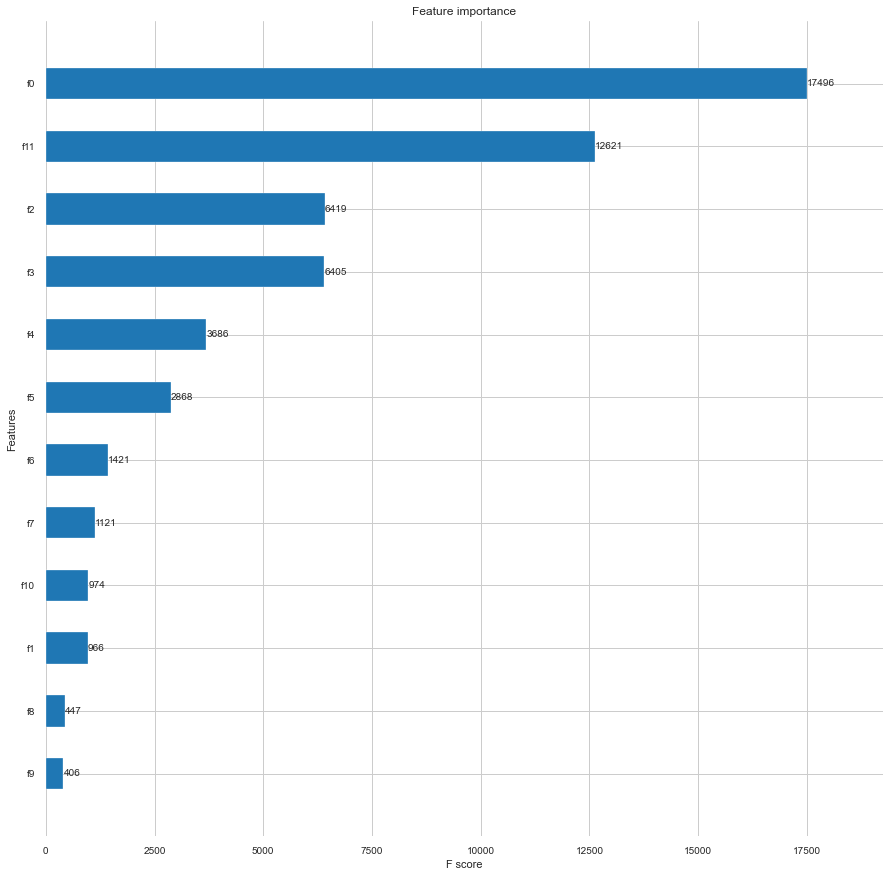

In [47]:
fig =  plt.figure(figsize = (15,15))
axes = fig.add_subplot(111)
xgb.plot_importance(XGB_Classifier,ax = axes,height =0.5)
plt.show();
plt.close()

### 4.11 LGBM Classifier <a class="anchor" id="5.11"></a>

Light GBM is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithms. It splits the tree leaf wise with the best fit whereas other boosting algorithms split the tree depth wise or level wise rather than leaf-wise. So when growing on the same leaf in Light GBM, the leaf-wise algorithm can reduce more loss than the level-wise algorithm and hence results in much better accuracy which can rarely be achieved by any of the existing boosting algorithms. Also, it is surprisingly very fast, hence the word ‘Light’. Reference [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/).

In [48]:
def hyperopt_lgb_score(params):
    clf = LGBMClassifier(**params)
    current_score = cross_val_score(clf, X_train, y_train, cv=10).mean()
    print(current_score, params)
    return current_score 
 
space_lgb = {
            'learning_rate': hp.quniform('learning_rate', 0, 0.05, 0.0001),
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'max_depth':  hp.choice('max_depth', np.arange(2, 12, dtype=int)),
            'num_leaves': hp.choice('num_leaves', 2*np.arange(2, 2**11, dtype=int)),
            'min_child_weight': hp.quniform('min_child_weight', 1, 9, 0.025),
            'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.005),
            'objective': 'binary',
            'boosting_type': 'gbdt',
            }
 
best = fmin(fn=hyperopt_lgb_score, space=space_lgb, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

0.7330373323667996                                                                                                     
{'boosting_type': 'gbdt', 'colsample_bytree': 0.92, 'learning_rate': 0.010400000000000001, 'max_depth': 4, 'min_child_weight': 5.9750000000000005, 'n_estimators': 405, 'num_leaves': 1134, 'objective': 'binary'}
0.7305183037332368                                                                                                     
{'boosting_type': 'gbdt', 'colsample_bytree': 0.935, 'learning_rate': 0.0221, 'max_depth': 10, 'min_child_weight': 3.4000000000000004, 'n_estimators': 713, 'num_leaves': 3268, 'objective': 'binary'}
0.7296303008336353                                                                                                     
{'boosting_type': 'gbdt', 'colsample_bytree': 0.66, 'learning_rate': 0.0005, 'max_depth': 4, 'min_child_weight': 8.6, 'n_estimators': 514, 'num_leaves': 1086, 'objective': 'binary'}
0.7294853207683943                              

In [49]:
params = space_eval(space_lgb, best)
params

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.74,
 'learning_rate': 0.0001,
 'max_depth': 8,
 'min_child_weight': 1.25,
 'n_estimators': 496,
 'num_leaves': 2638,
 'objective': 'binary'}

In [50]:
LGB_Classifier = LGBMClassifier(**params)
LGB_Classifier.fit(X_train, y_train)
acc_LGB_Classifier = round(LGB_Classifier.score(X_train, y_train) * 100, 2)
acc_LGB_Classifier

72.65

In [51]:
acc_test_LGB_Classifier = round(LGB_Classifier.score(X_test, y_test) * 100, 2)
acc_test_LGB_Classifier

71.48

### 5.12 GradientBoostingClassifier <a class="anchor" id="5.12"></a>

**Gradient Boosting** builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage n_classes_ regression trees are fit on the negative gradient of the binomial or multinomial deviance loss function. Binary classification is a special case where only a single regression tree is induced. The features are always randomly permuted at each split. Therefore, the best found split may vary, even with the same training data and max_features=n_features, if the improvement of the criterion is identical for several splits enumerated during the search of the best split. To obtain a deterministic behaviour during fitting, random_state has to be fixed. Reference [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html).

In [52]:
def hyperopt_gb_score(params):
    clf = GradientBoostingClassifier(**params)
    current_score = cross_val_score(clf, X_train, y_train, cv=10).mean()
    print(current_score, params)
    return current_score 
 
space_gb = {
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'max_depth': hp.choice('max_depth', np.arange(2, 10, dtype=int))            
        }
 
best = fmin(fn=hyperopt_gb_score, space=space_gb, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

0.7274012323305545                                                                                                     
{'max_depth': 8, 'n_estimators': 204}                                                                                  
0.7183581007611453                                                                                                     
{'max_depth': 7, 'n_estimators': 724}                                                                                  
0.7292134831460674                                                                                                     
{'max_depth': 8, 'n_estimators': 102}                                                                                  
0.7325299021384559                                                                                                     
{'max_depth': 4, 'n_estimators': 380}                                                                                  
0.7247191011235955                      

In [53]:
 params = space_eval(space_gb, best)
params

{'max_depth': 9, 'n_estimators': 359}

In [54]:
# Gradient Boosting Classifier

gradient_boosting = GradientBoostingClassifier(**params)
gradient_boosting.fit(X_train, y_train)
acc_gradient_boosting = round(gradient_boosting.score(X_train, y_train) * 100, 2)
acc_gradient_boosting

89.68

In [55]:
acc_test_gradient_boosting = round(gradient_boosting.score(X_test, y_test) * 100, 2)
acc_test_gradient_boosting

72.29

### 5.13 RidgeClassifier <a class="anchor" id="5.13"></a>

Tikhonov Regularization, colloquially known as **Ridge Regression**, is the most commonly used regression algorithm to approximate an answer for an equation with no unique solution. This type of problem is very common in machine learning tasks, where the "best" solution must be chosen using limited data. If a unique solution exists, algorithm will return the optimal value. However, if multiple solutions exist, it may choose any of them. Reference [Brilliant.org](https://brilliant.org/wiki/ridge-regression/).

In [56]:
ridge_classifier = RidgeClassifier()
ridge_classifier.fit(X_train, y_train)
acc_ridge_classifier = round(ridge_classifier.score(X_train, y_train) * 100, 2)
acc_ridge_classifier

72.34

In [57]:
acc_test_ridge_classifier = round(ridge_classifier.score(X_test, y_test) * 100, 2)
acc_test_ridge_classifier

72.58

### 4.14 BaggingClassifier <a class="anchor" id="5.14"></a>

Bootstrap aggregating, also called **bagging**, is a machine learning ensemble meta-algorithm designed to improve the stability and accuracy of machine learning algorithms used in statistical classification and regression. It also reduces variance and helps to avoid overfitting. Although it is usually applied to decision tree methods, it can be used with any type of method. Bagging is a special case of the model averaging approach. Bagging leads to "improvements for unstable procedures", which include, for example, artificial neural networks, classification and regression trees, and subset selection in linear regression. On the other hand, it can mildly degrade the performance of stable methods such as K-nearest neighbors. Reference [Wikipedia](https://en.wikipedia.org/wiki/Bootstrap_aggregating).

A **Bagging classifier** is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it. Reference [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html).

In [58]:
bagging_classifier = BaggingClassifier()
bagging_classifier.fit(X_train, y_train)
Y_pred = bagging_classifier.predict(X_test).astype(int)
acc_bagging_classifier = round(bagging_classifier.score(X_train, y_train) * 100, 2)
acc_bagging_classifier

98.01

In [59]:
acc_test_bagging_classifier = round(bagging_classifier.score(X_test, y_test) * 100, 2)
acc_test_bagging_classifier

69.29

### 4.15 ExtraTreesClassifier <a class="anchor" id="5.15"></a>

**ExtraTreesClassifier** implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The default values for the parameters controlling the size of the trees (e.g. max_depth, min_samples_leaf, etc.) lead to fully grown and unpruned trees which can potentially be very large on some data sets. To reduce memory consumption, the complexity and size of the trees should be controlled by setting those parameter values. Reference [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html). 

In extremely randomized trees, randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias. Reference [sklearn documentation](https://scikit-learn.org/stable/modules/ensemble.html#Extremely%20Randomized%20Trees).

In [60]:
def hyperopt_etc_score(params):
    clf = ExtraTreesClassifier(**params)
    current_score = cross_val_score(clf, X_train, y_train, cv=10).mean()
    print(current_score, params)
    return current_score 
 
space_etc = {
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'max_features': hp.choice('max_features', np.arange(2, 17, dtype=int)),
            'min_samples_leaf': hp.choice('min_samples_leaf', np.arange(1, 5, dtype=int)),
            'max_depth':  hp.choice('max_depth', np.arange(2, 12, dtype=int)),
            'max_features': None # for small number of features
        }
 
best = fmin(fn=hyperopt_etc_score, space=space_etc, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

0.7334360275462124                                                                                                     
{'max_depth': 11, 'max_features': None, 'min_samples_leaf': 3, 'n_estimators': 149}                                    
0.7319499818774918                                                                                                     
{'max_depth': 7, 'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 263}                                     
0.7037694816962669                                                                                                     
{'max_depth': 2, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 216}                                     
0.7313519391083726                                                                                                     
{'max_depth': 6, 'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 291}                                     
0.7320587169264228                      

In [61]:
params = space_eval(space_etc, best)
params

{'max_depth': 2,
 'max_features': None,
 'min_samples_leaf': 1,
 'n_estimators': 216}

In [62]:
extra_trees_classifier = ExtraTreesClassifier(**params)
extra_trees_classifier.fit(X_train, y_train)
acc_etc = round(extra_trees_classifier.score(X_train, y_train) * 100, 2)
acc_etc

70.91

In [63]:
acc_test_etc = round(extra_trees_classifier.score(X_test, y_test) * 100, 2)
acc_test_etc

71.15

## 5. Models evaluation <a class="anchor" id="6"></a>

In [64]:

models = pd.DataFrame({
       'Model': ['Logistic Regression', 'Support Vector Machines', 'Linear SVC', 'k-Nearest Neighbors', 'Naive Bayes', 
              'Perceptron',
              'Decision Tree Classifier', 'Random Forest', 'Stochastic Gradient Decent',   'XGBClassifier', 'LGBMClassifier',
              'GradientBoostingClassifier', 'RidgeClassifier', 'BaggingClassifier', 'ExtraTreesClassifier', ],
    
    'Score_train': [acc_log, acc_svc, acc_linear_svc, acc_knn, acc_gaussian, 
              acc_perceptron, 
              acc_decision_tree, acc_random_forest, acc_sgd, acc_XGB_Classifier, acc_LGB_Classifier,
              acc_gradient_boosting, acc_ridge_classifier, acc_bagging_classifier, acc_etc, 
              ],
    'Score_test': [acc_test_log, acc_test_svc, acc_test_linear_svc, acc_test_knn, acc_test_gaussian, 
              acc_test_perceptron, 
              acc_test_decision_tree, acc_test_random_forest, acc_test_sgd, acc_test_XGB_Classifier, acc_test_LGB_Classifier,
              acc_test_gradient_boosting, acc_test_ridge_classifier, acc_test_bagging_classifier, acc_test_etc, 
             ]
                    })

In [65]:
models.sort_values(by=['Score_train', 'Score_test'], ascending=False)

,Model,Score_train,Score_test
7,Random Forest,99.981877,71.591156
13,BaggingClassifier,98.010000,69.290000
11,GradientBoostingClassifier,89.680000,72.290000
9,XGBClassifier,80.110000,73.100000
6,Decision Tree Classifier,72.676694,73.127945
10,LGBMClassifier,72.650000,71.480000
2,Linear SVC,72.374049,72.729250
12,RidgeClassifier,72.340000,72.580000
3,k-Nearest Neighbors,72.133019,70.598043
0,Logistic Regression,71.652773,71.939108


In [66]:
models.sort_values(by=['Score_test', 'Score_train'], ascending=False)

,Model,Score_train,Score_test
6,Decision Tree Classifier,72.676694,73.127945
9,XGBClassifier,80.110000,73.100000
2,Linear SVC,72.374049,72.729250
12,RidgeClassifier,72.340000,72.580000
11,GradientBoostingClassifier,89.680000,72.290000
0,Logistic Regression,71.652773,71.939108
7,Random Forest,99.981877,71.591156
10,LGBMClassifier,72.650000,71.480000
14,ExtraTreesClassifier,70.910000,71.150000
8,Stochastic Gradient Decent,70.550000,70.910000


In [67]:
models['Score_diff'] = abs(models['Score_train'] - models['Score_test'])
models.sort_values(by=['Score_diff'], ascending=True)

,Model,Score_train,Score_test,Score_diff
4,Naive Bayes,70.266401,70.264589,0.001812
12,RidgeClassifier,72.340000,72.580000,0.240000
14,ExtraTreesClassifier,70.910000,71.150000,0.240000
0,Logistic Regression,71.652773,71.939108,0.286336
2,Linear SVC,72.374049,72.729250,0.355201
8,Stochastic Gradient Decent,70.550000,70.910000,0.360000
6,Decision Tree Classifier,72.676694,73.127945,0.451250
5,Perceptron,63.300109,62.587894,0.712215
1,Support Vector Machines,61.495107,60.724900,0.770207
10,LGBMClassifier,72.650000,71.480000,1.170000


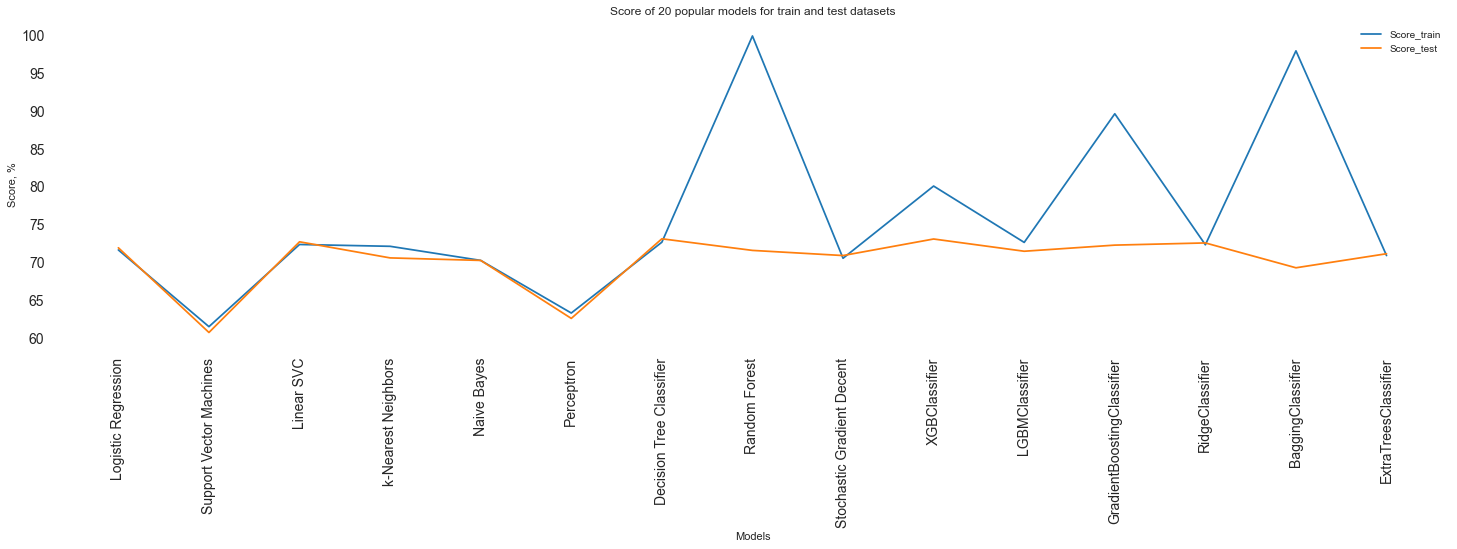

In [68]:
# Plot
plt.figure(figsize=[25,6])
xx = models['Model']
plt.tick_params(labelsize=14)
plt.plot(xx, models['Score_train'], label = 'Score_train')
plt.plot(xx, models['Score_test'], label = 'Score_test')
plt.legend()
plt.title('Score of 20 popular models for train and test datasets')
plt.xlabel('Models')
plt.ylabel('Score, %')
plt.xticks(xx, rotation='vertical')
plt.savefig('graph.png')
plt.show()